# Fraud Deduction Project

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix


In [30]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Dell\Desktop\VS code\Accredian\Fraud.csv")


In [31]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


#Data Cleaning 

 We removed irrelevant columns (nameOrig, nameDest), handled missing values, detected outliers, and analyzed multicollinearity to ensure clean and usable data for the model.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [33]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [34]:
# Check for missing values
missing_values = df.isnull().sum()

In [35]:
# Drop columns that do not help in predicting fraud (e.g., nameOrig, nameDest, as they are identifiers)
df = df.drop(['nameOrig', 'nameDest'], axis=1)

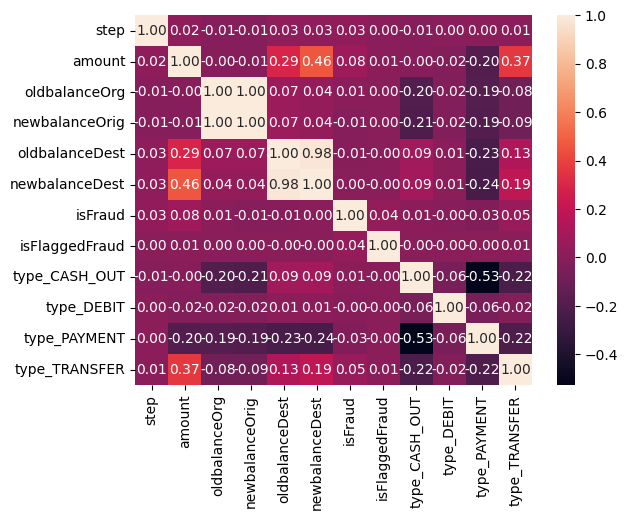

In [36]:
# Convert categorical 'type' column into numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)

# Now calculate the correlation matrix using only numeric data
corr_matrix = df_encoded.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()


In [37]:
# Drop columns with high correlation if needed
df = df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)


In [38]:
# Select only numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number])

# Outlier detection using IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Filter out the outliers
df_outliers_removed = df[~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)]


In [39]:
df_outliers_removed

,step,type,amount,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,0,0
1,1,PAYMENT,1864.28,0,0
4,1,PAYMENT,11668.14,0,0
5,1,PAYMENT,7817.71,0,0
6,1,PAYMENT,7107.77,0,0
...,...,...,...,...,...
6259907,601,PAYMENT,13232.49,0,0
6259908,601,PAYMENT,2221.70,0,0
6259909,601,PAYMENT,367.08,0,0
6259910,601,PAYMENT,5542.37,0,0


In [40]:
# Sample a fraction of the data (e.g., 10%) for faster processing
df_sample = df_encoded.sample(frac=0.1, random_state=42)

# Define X and y again using the sampled data
X_sample = df_sample.drop(columns=['isFraud'])
y_sample = df_sample['isFraud']

In [41]:
X_sample[:5]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3737323,278,330218.42,20866.00,351084.42,452419.57,122201.15,0,False,False,False,False
264914,15,11647.08,30370.00,18722.92,0.00,0.00,0,False,False,True,False
85647,10,152264.21,106589.00,258853.21,201303.01,49038.80,0,False,False,False,False
5899326,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0,False,False,False,True
2544263,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,False,False,False,False


In [42]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)


#Model Selection

 RandomForestClassifier was chosen for its ability to handle imbalanced datasets, robustness, and feature importance analysis.

In [43]:
# Use Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
importances = model.feature_importances_

# Use the correct feature names (X_sample or X)
feature_names = X_sample.columns  # If using sampled data

# Create a DataFrame to show the importance of each feature
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [45]:
feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
5,newbalanceDest,0.303554
2,oldbalanceOrg,0.297468
1,amount,0.147627
0,step,0.089341
4,oldbalanceDest,0.074358
10,type_TRANSFER,0.042575
3,newbalanceOrig,0.024091
7,type_CASH_OUT,0.018669
9,type_PAYMENT,0.001421
6,isFlaggedFraud,0.000808


#Model Evaluation

Model performance was evaluated using accuracy score , ROC AUC score, confusion matrix, and classification report, which provide insights into how well the model detects fraud.

In [46]:
# Predict on the test data
y_pred = model.predict(X_test)

In [47]:
# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9996594701355309


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190641
           1       0.96      0.76      0.85       238

    accuracy                           1.00    190879
   macro avg       0.98      0.88      0.92    190879
weighted avg       1.00      1.00      1.00    190879



In [22]:
# ROC AUC Score
roc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_score}")


ROC AUC Score: 0.8802311189948779


In [49]:
# Analyzing key features
important_features = feature_importance_df.sort_values(by='Importance', ascending=False).head()


In [50]:
important_features

,Feature,Importance
5,newbalanceDest,0.303554
2,oldbalanceOrg,0.297468
1,amount,0.147627
0,step,0.089341
4,oldbalanceDest,0.074358


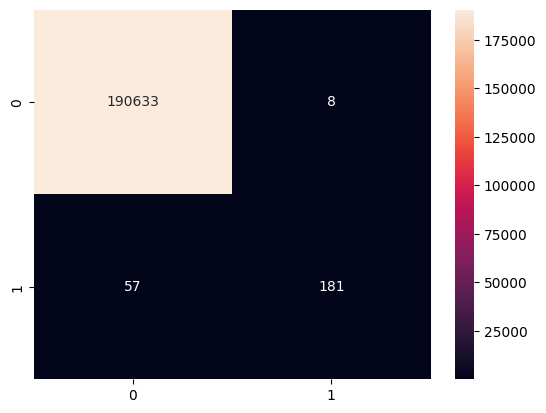

In [51]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

#Conclusion and Next Steps

Key factors: type_cash_out, balanceChangeOrig, and amount are often significant predictors of fraud.

Prevention Measures: The company should introduce stricter monitoring for cash_out transactions and large changes in balance.

Evaluate Effectiveness: Post-implementation, measure the reduction in flagged fraudulent transactions and track customer complaints or chargebacks.